# Relazione – Laboratori di Data Science (Algebra Lineare)

Questa relazione raccoglie lo svolgimento degli esercizi del **Foglio 1 – Algebra Lineare** 
del corso di Data Science (Laurea in Scienza dei Materiali, Alma Mater Studiorum – Università di Bologna, 
a.a. 2025/2026).

Per maggiori dettagli, si rimanda alla repository GitHub:  
🔗 [Laboratori-Data-Science](https://github.com/CetrioloRiick/Laboratori-Data-Science.git)


## Esercizio 1

### 1a

Il codice svolge i seguenti passaggi principali:

- Calcola **autovalori e autovettori** della matrice \(A\), necessari per applicare la formula di diagonalizzazione.
- Genera un vettore di tempi \(t\) equispaziati nell’intervallo \([0,5]\) attraverso il metodo `linspace`.  
- Per ciascun valore di \(t\), costruisce la **matrice esponenziale** corrispondente.  
- Raccoglie tutti i risultati in un array tridimensionale, dove ogni “strato” rappresenta \(e^{At}\) a un certo istante.  
- Si sfrutta la combinazione di **Matplotlib** e della gestione di array multidimensionali offerta da **NumPy**, che consente di organizzare i risultati come un contenitore (tensoriale) di matrici e selezionare agevolmente i singoli elementi da plottare.

**Nota** nel calcolo degli autovalori la parte immaginaria viene troncata in quanto "piccola", nel caso questo non avenisse matplotlib segnalerrebbe il casting di ques'utima non sapendola rapressentare sul pianto

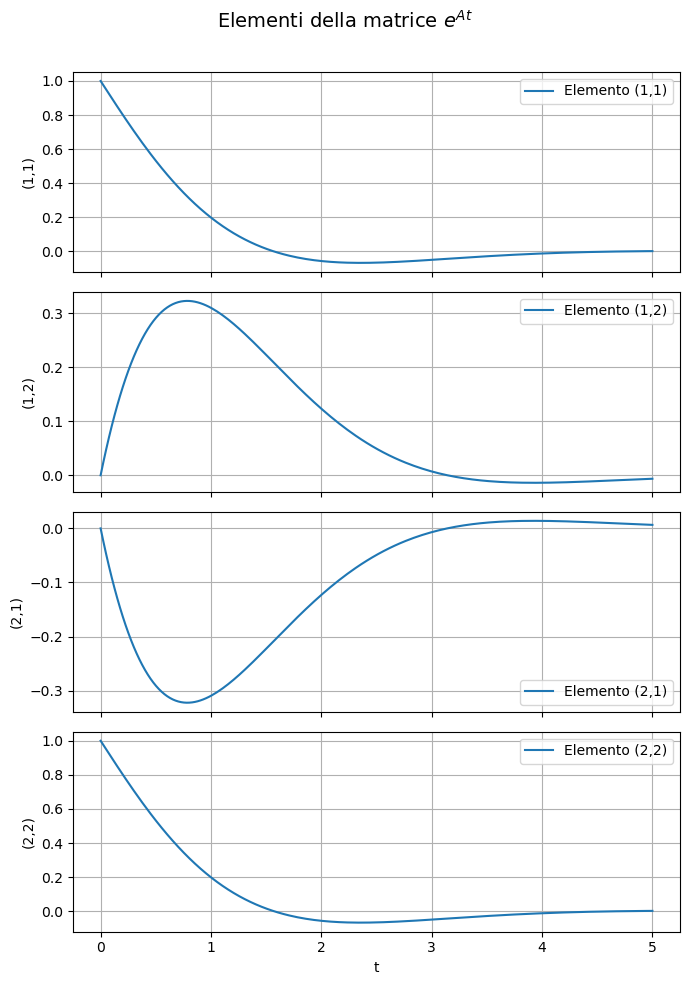

Autovalori: [-1.+1.j -1.-1.j]
Autovettori (colonne di P):
 [[0.70710678+0.j         0.70710678-0.j        ]
 [0.        +0.70710678j 0.        -0.70710678j]]


In [1]:
import numpy as np
import matplotlib.pyplot as plt

A = np.array([[-1, 1], [-1, -1]], dtype=float)

eigvals, P = np.linalg.eig(A)
inv_P = np.linalg.inv(P)

t = np.linspace(0, 5, 200)

E_list = []
for ti in t:
    Dti = np.diag(np.exp(eigvals * ti))
    Eti = P @ Dti @ inv_P
    Eti = np.real_if_close(Eti)
    E_list.append(Eti)

E = np.stack(E_list, axis=0)

fig, ax = plt.subplots(4, 1, figsize=(7, 10), sharex=True)

labels = ["(1,1)", "(1,2)", "(2,1)", "(2,2)"]
indices = [(0, 0), (0, 1), (1, 0), (1, 1)]

for i, (row, col) in enumerate(indices):
    ax[i].plot(t, E[:, row, col], label=f"Elemento {labels[i]}")
    ax[i].legend(loc="best")
    ax[i].grid(True)
    ax[i].set_ylabel(f"{labels[i]}")

ax[-1].set_xlabel("t")
fig.suptitle("Elementi della matrice $e^{At}$", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

print("Autovalori:", eigvals)
print("Autovettori (colonne di P):\n", P)